                                  Open         High          Low        Close  \
Date                                                                            
2014-08-20 00:00:00+01:00  6779.299805  6781.200195  6739.799805  6755.500000   
2014-08-21 00:00:00+01:00  6755.500000  6780.700195  6752.700195  6777.700195   
2014-08-22 00:00:00+01:00  6777.700195  6784.600098  6746.399902  6775.299805   
2014-08-26 00:00:00+01:00  6775.299805  6827.299805  6775.299805  6822.799805   
2014-08-27 00:00:00+01:00  6822.799805  6830.700195  6813.200195  6830.700195   

                              Volume  Dividends  Stock Splits  
Date                                                           
2014-08-20 00:00:00+01:00  466211000        0.0           0.0  
2014-08-21 00:00:00+01:00  423431000        0.0           0.0  
2014-08-22 00:00:00+01:00  571522600        0.0           0.0  
2014-08-26 00:00:00+01:00  538317700        0.0           0.0  
2014-08-27 00:00:00+01:00  481233300        0.0 

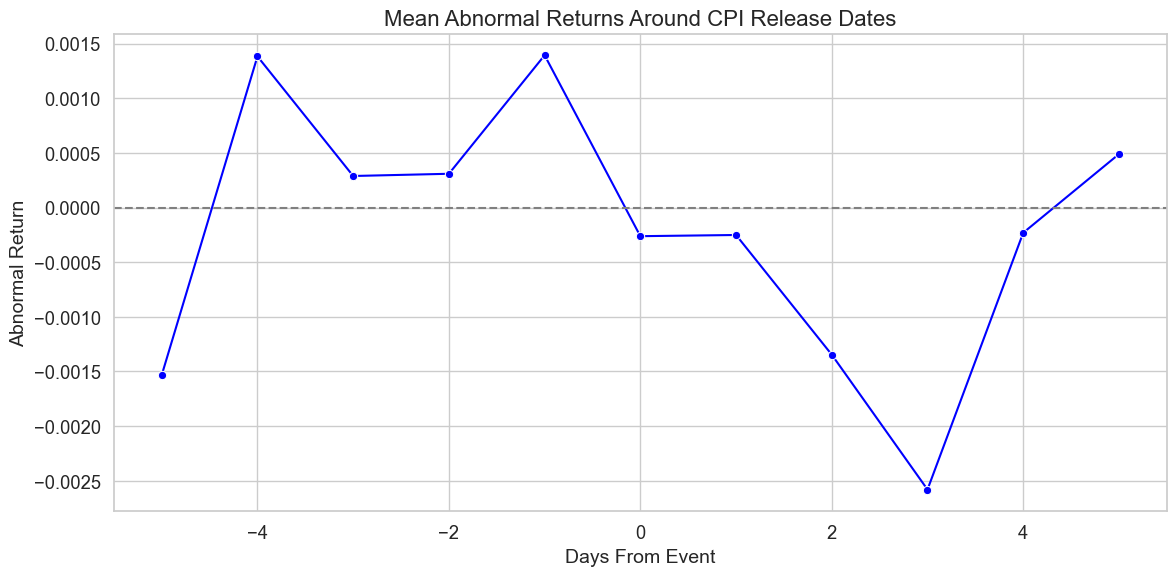

Window Size: 5, CPI Releases: T-Statistic = 0.1356, P-Value = 0.8922


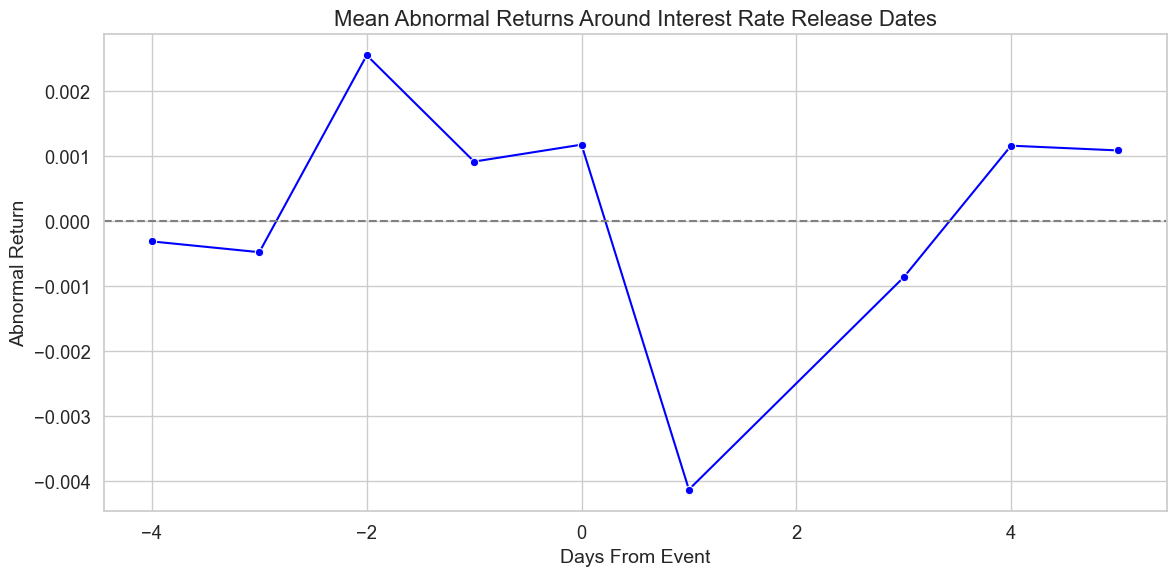

Window Size: 5, Interest Rate Releases: T-Statistic = 1.1136, P-Value = 0.2659


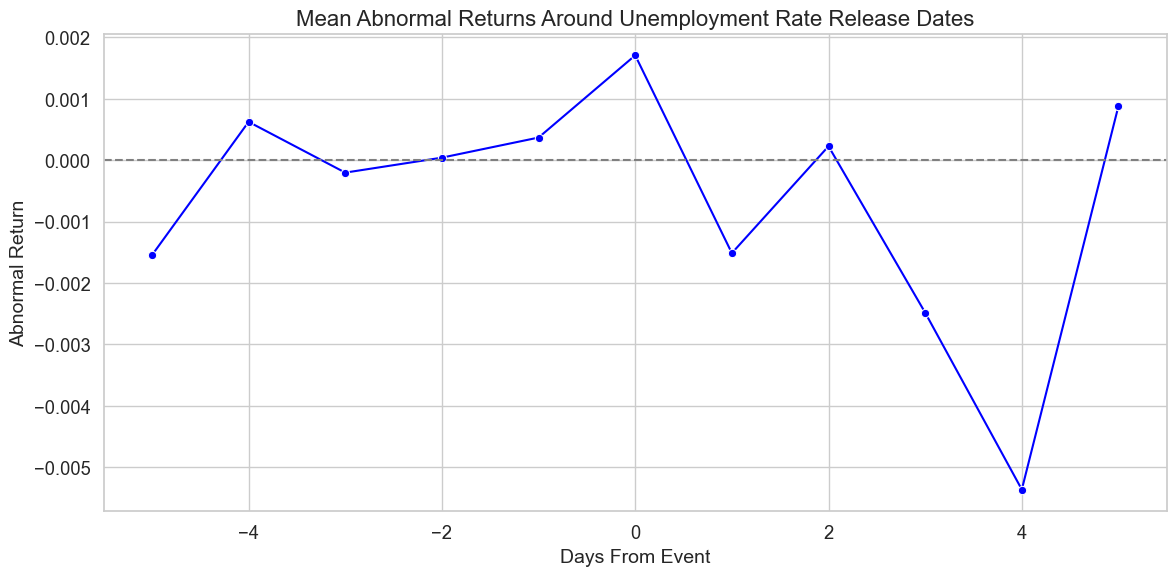

Window Size: 5, Unemployment Rate Releases: T-Statistic = -0.4313, P-Value = 0.6664


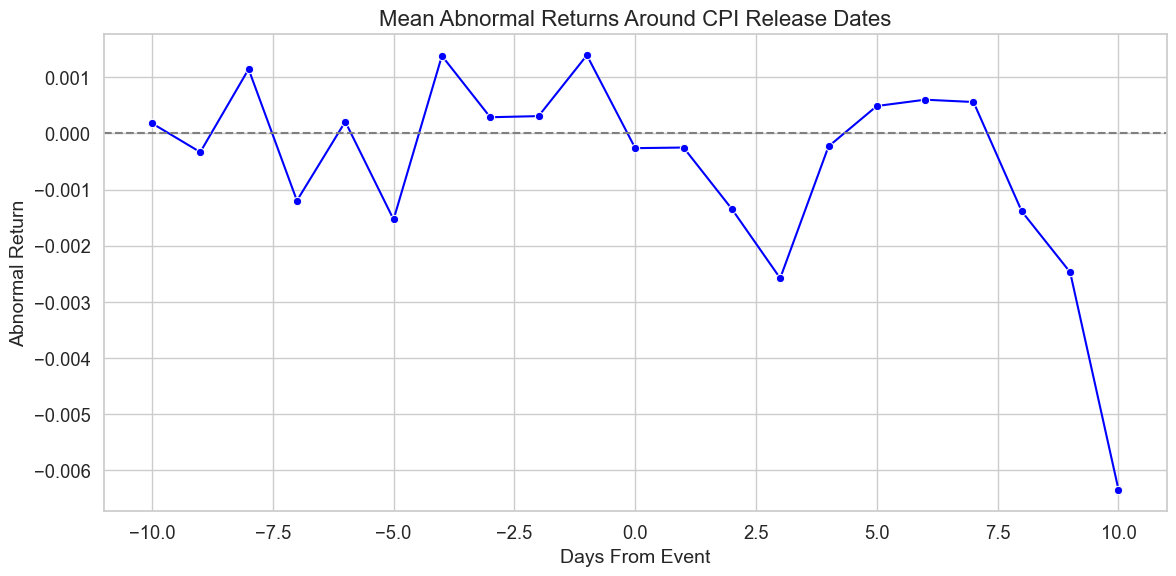

Window Size: 10, CPI Releases: T-Statistic = -0.3310, P-Value = 0.7407


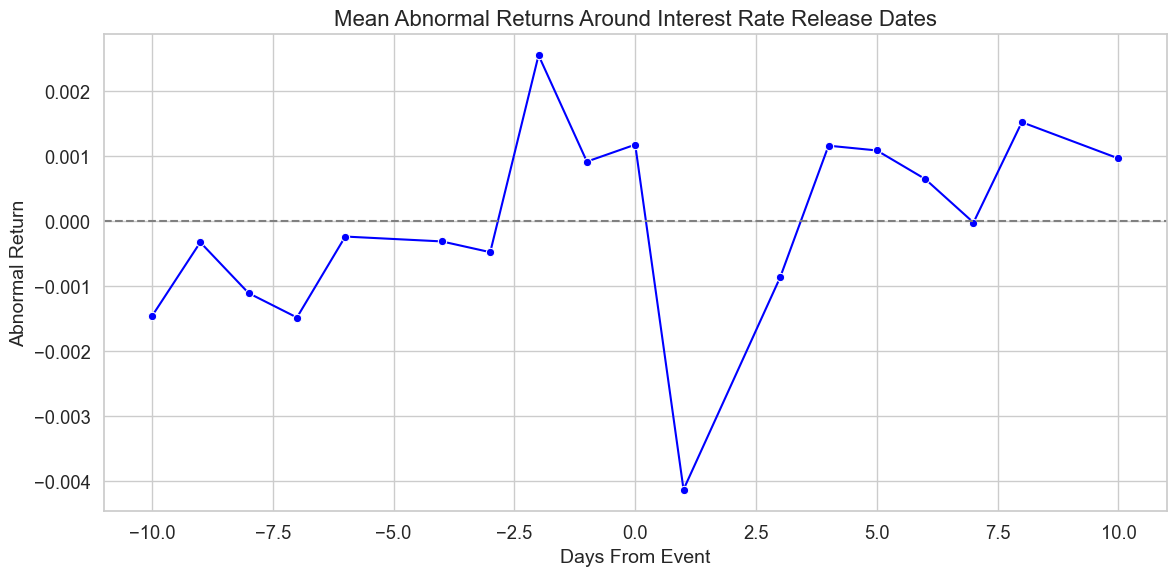

Window Size: 10, Interest Rate Releases: T-Statistic = 0.2329, P-Value = 0.8159


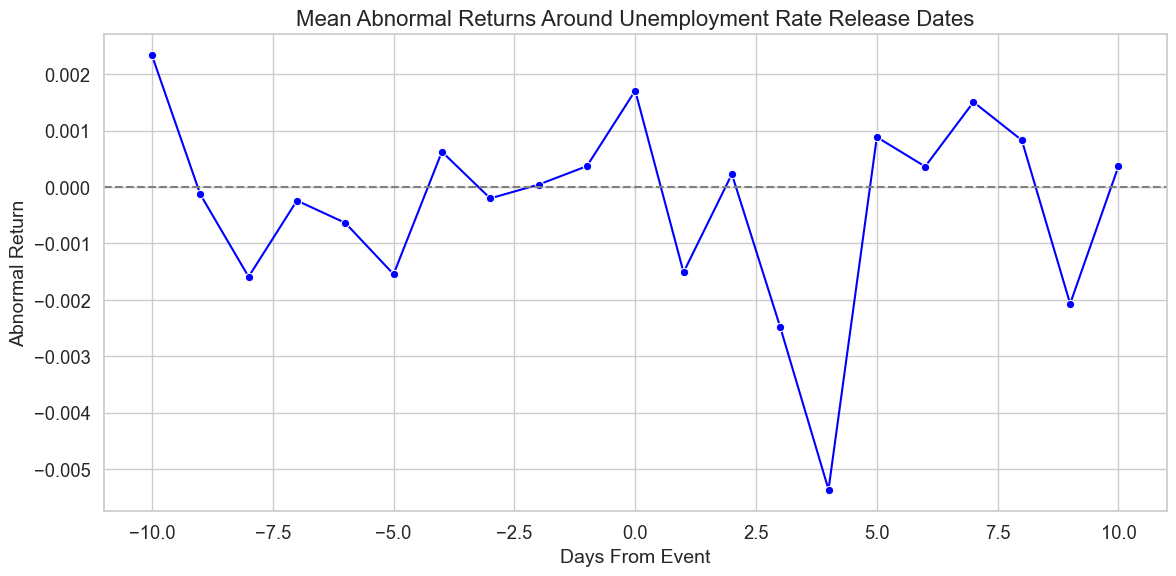

Window Size: 10, Unemployment Rate Releases: T-Statistic = -0.6780, P-Value = 0.4979


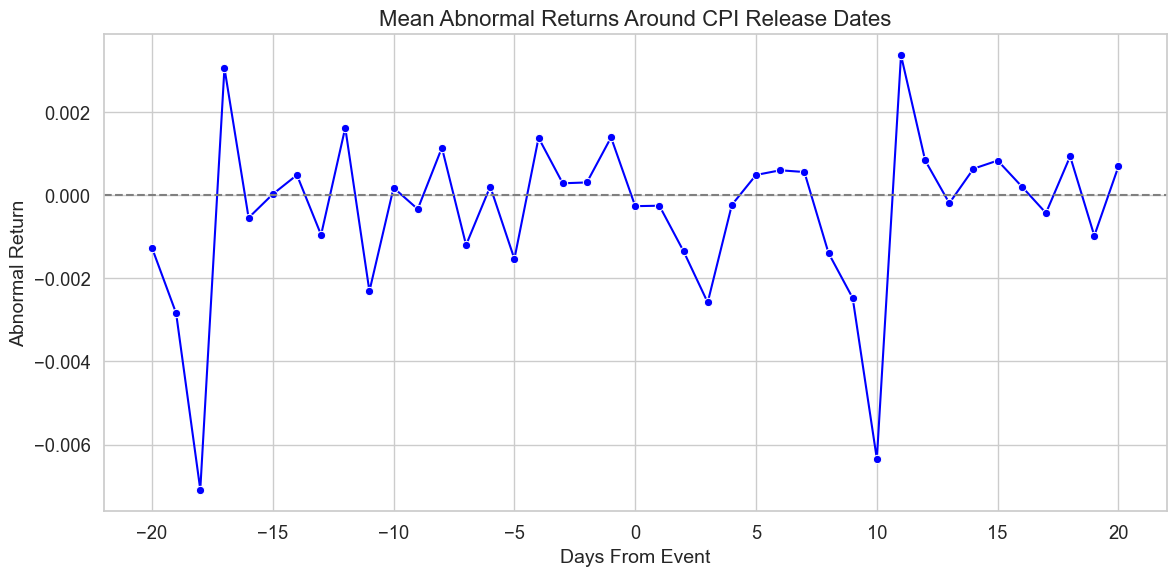

Window Size: 20, CPI Releases: T-Statistic = 0.1849, P-Value = 0.8533


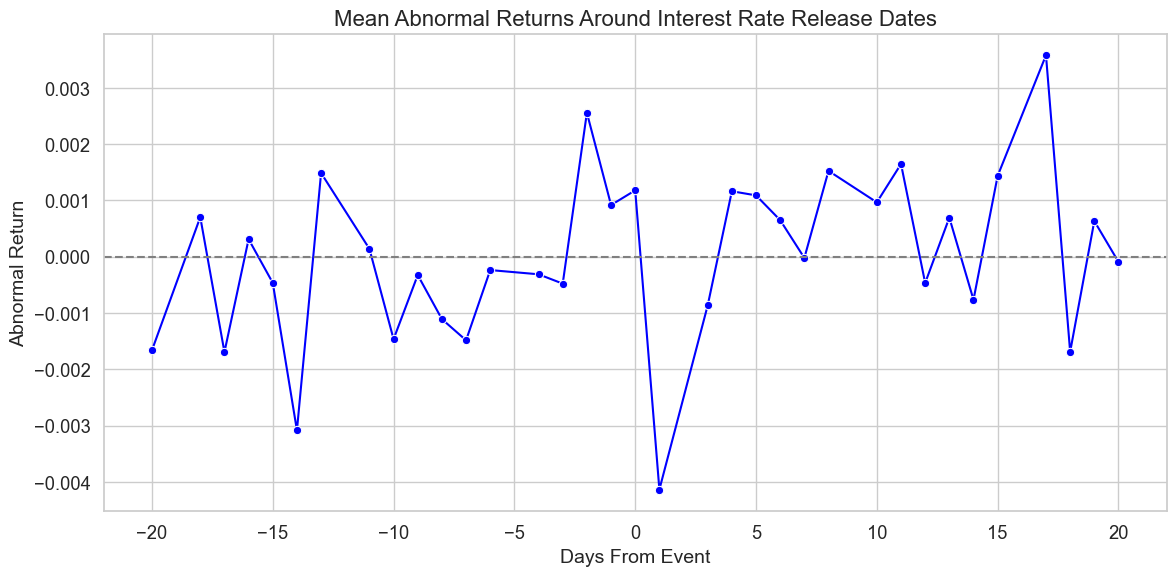

Window Size: 20, Interest Rate Releases: T-Statistic = -0.1720, P-Value = 0.8635


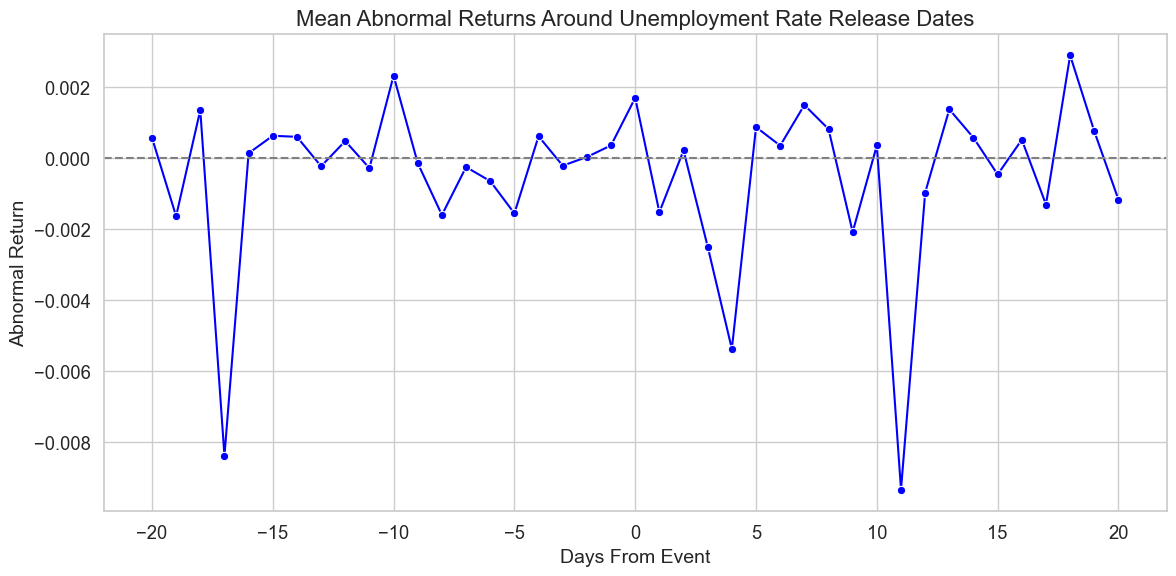

Window Size: 20, Unemployment Rate Releases: T-Statistic = -0.3908, P-Value = 0.6960


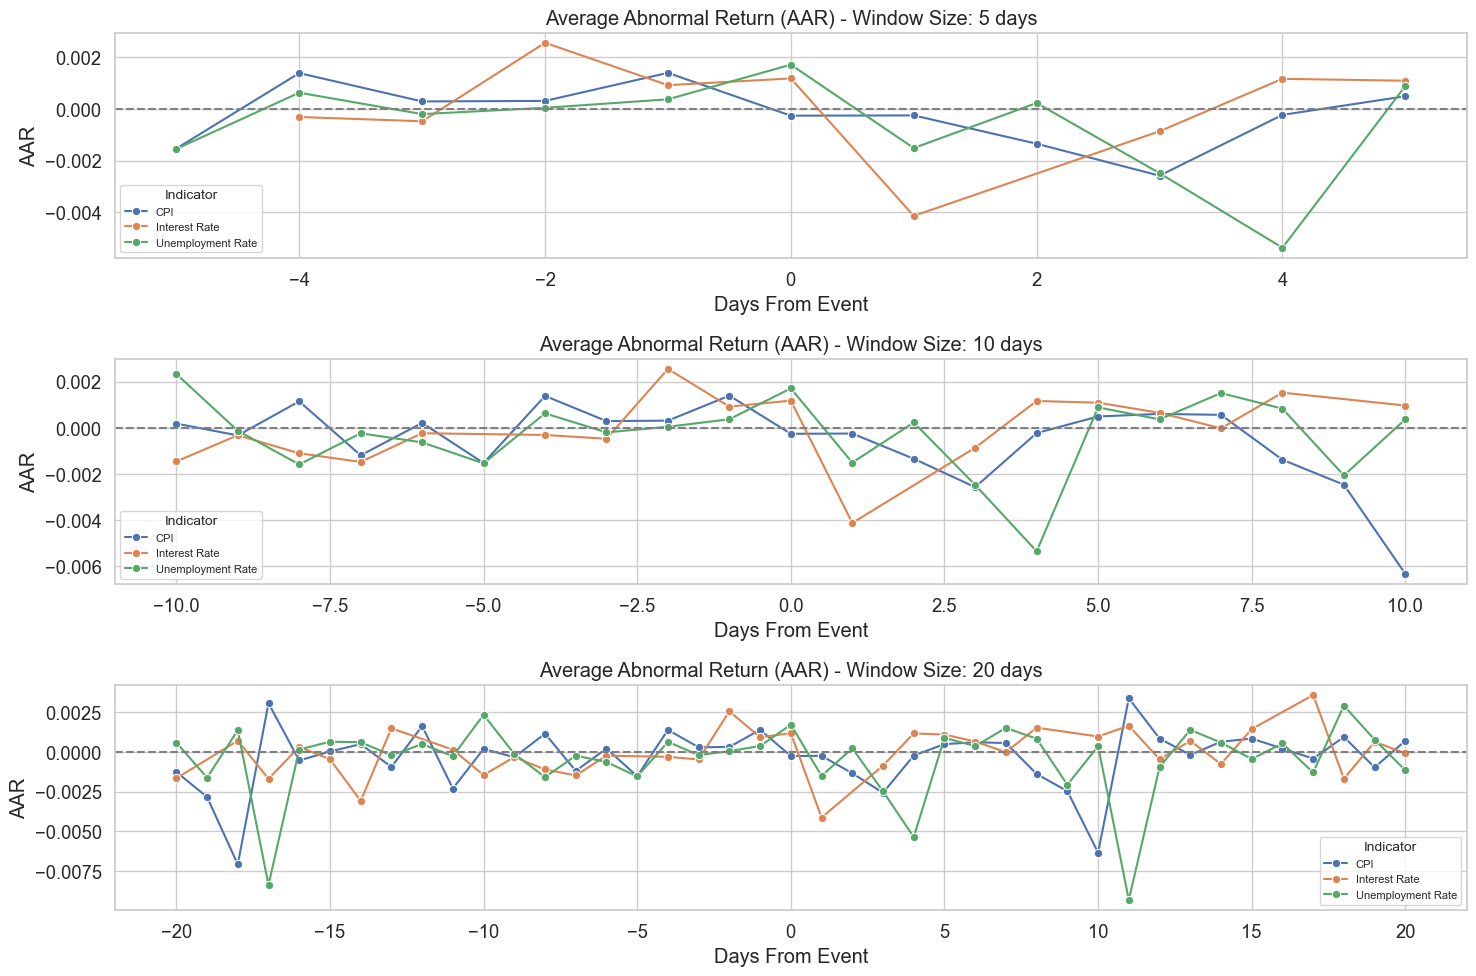


Analysis for 5-day event window:


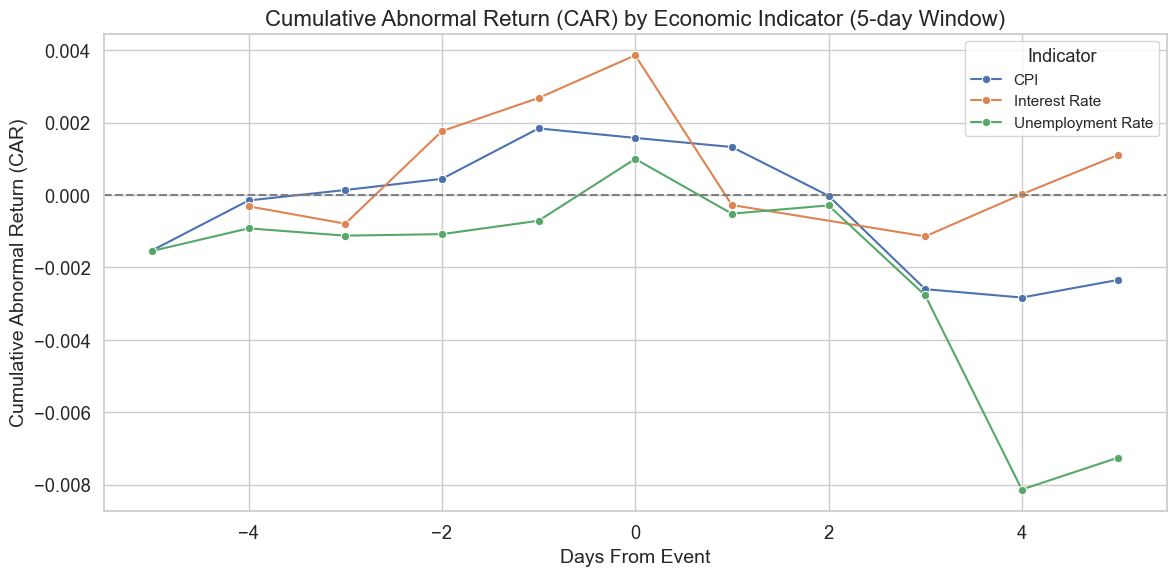

,CPI,Interest Rate,Unemployment Rate
count,11.0000,9.0000,11.0000
mean,-0.0002,0.0001,-0.0007
std,0.0012,0.0019,0.0020
min,-0.0026,-0.0041,-0.0054
25%,-0.0008,-0.0005,-0.0015
50%,-0.0002,0.0009,0.0000
75%,0.0004,0.0012,0.0005
max,0.0014,0.0026,0.0017


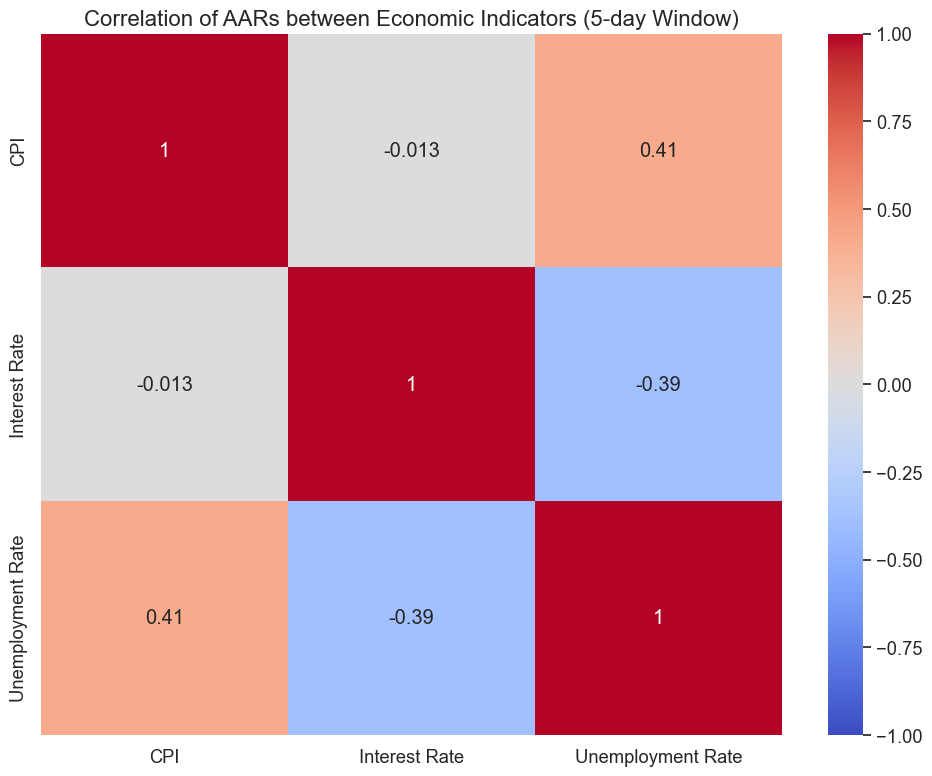

ANOVA results for 5-day window:
F-statistic: 0.5199, P-value: 0.6002

Pairwise t-test results for 5-day window:


,T-Statistic,P-Value,Significant
Comparison,,,
CPI vs Interest Rate,-0.4778,0.6385,0.0000
CPI vs Unemployment Rate,0.6371,0.5313,0.0000
Interest Rate vs Unemployment Rate,0.8922,0.3840,0.0000



Summary Comparison Across All Window Sizes:


,CPI_T-Stat,Interest Rate_T-Stat,Unemployment Rate_T-Stat,CPI_P-Value,Interest Rate_P-Value,Unemployment Rate_P-Value
5,0.1356,1.1136,-0.4313,0.8922,0.2659,0.6664
10,-0.3310,0.2329,-0.6780,0.7407,0.8159,0.4979
20,0.1849,-0.1720,-0.3908,0.8533,0.8635,0.6960



Analysis for 10-day event window:


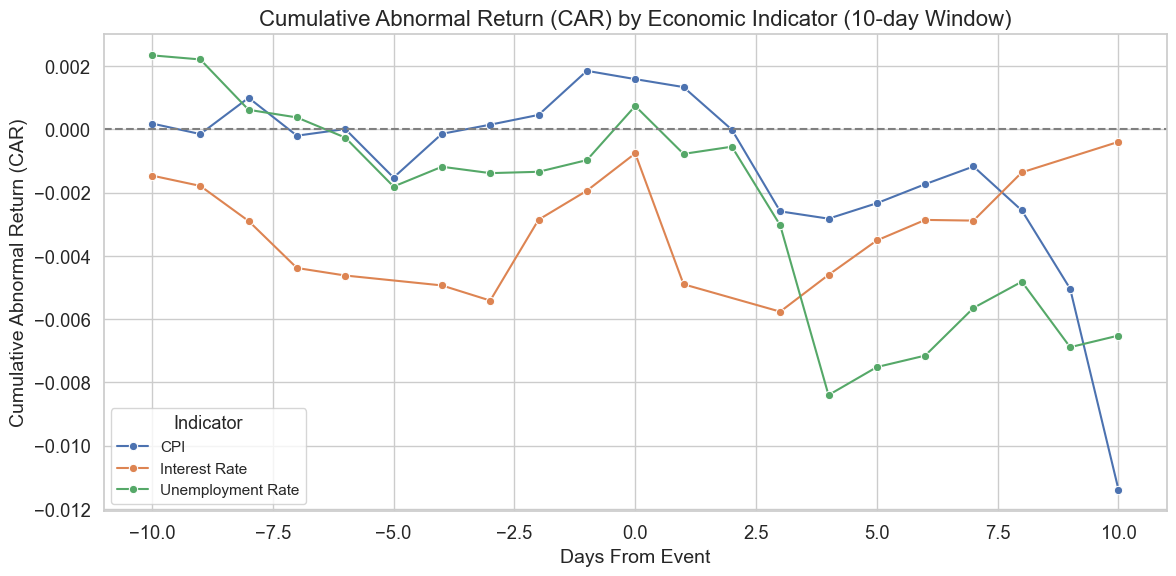

,CPI,Interest Rate,Unemployment Rate
count,21.0000,18.0000,21.0000
mean,-0.0005,-0.0000,-0.0003
std,0.0017,0.0015,0.0017
min,-0.0063,-0.0041,-0.0054
25%,-0.0013,-0.0008,-0.0015
50%,-0.0002,-0.0001,0.0000
75%,0.0005,0.0011,0.0006
max,0.0014,0.0026,0.0023


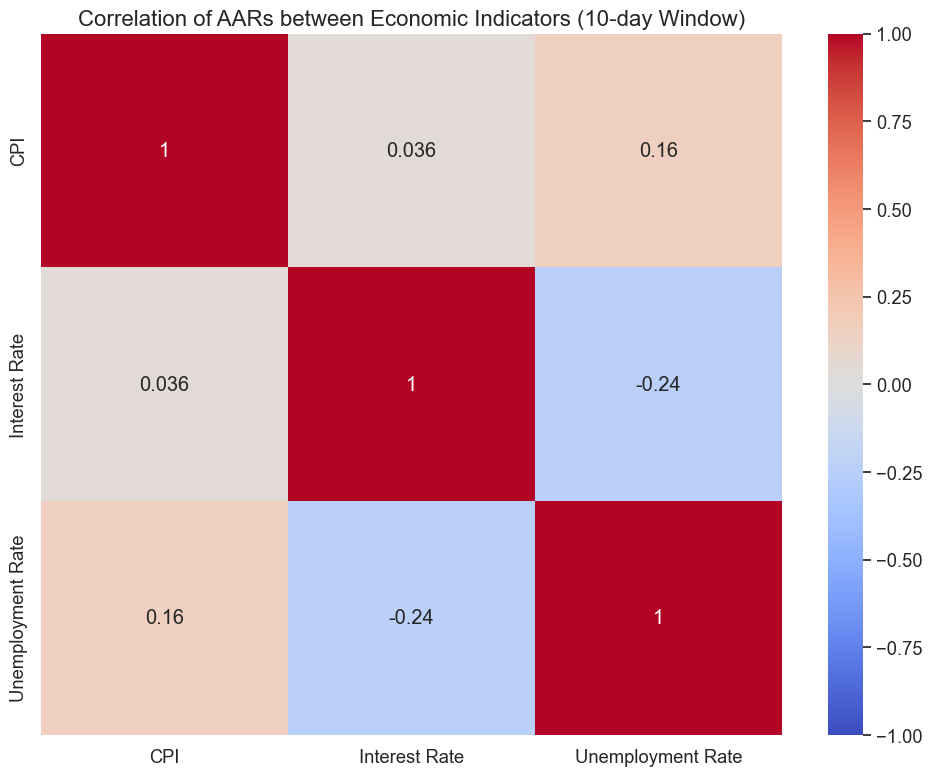

ANOVA results for 10-day window:
F-statistic: 0.4735, P-value: 0.6252

Pairwise t-test results for 10-day window:


,T-Statistic,P-Value,Significant
Comparison,,,
CPI vs Interest Rate,-0.9853,0.3309,0.0000
CPI vs Unemployment Rate,-0.4354,0.6656,0.0000
Interest Rate vs Unemployment Rate,0.5550,0.5822,0.0000



Summary Comparison Across All Window Sizes:


,CPI_T-Stat,Interest Rate_T-Stat,Unemployment Rate_T-Stat,CPI_P-Value,Interest Rate_P-Value,Unemployment Rate_P-Value
5,0.1356,1.1136,-0.4313,0.8922,0.2659,0.6664
10,-0.3310,0.2329,-0.6780,0.7407,0.8159,0.4979
20,0.1849,-0.1720,-0.3908,0.8533,0.8635,0.6960



Analysis for 20-day event window:


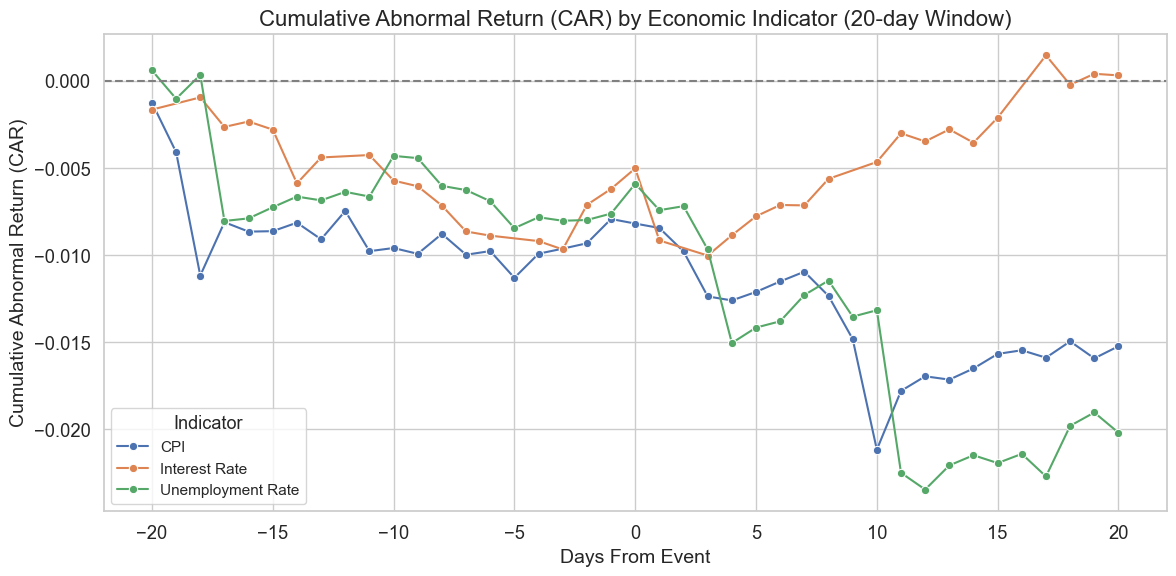

,CPI,Interest Rate,Unemployment Rate
count,41.0000,35.0000,41.0000
mean,-0.0004,0.0000,-0.0005
std,0.0020,0.0015,0.0024
min,-0.0071,-0.0041,-0.0093
25%,-0.0012,-0.0008,-0.0012
50%,0.0000,-0.0000,0.0001
75%,0.0006,0.0010,0.0006
max,0.0034,0.0036,0.0029


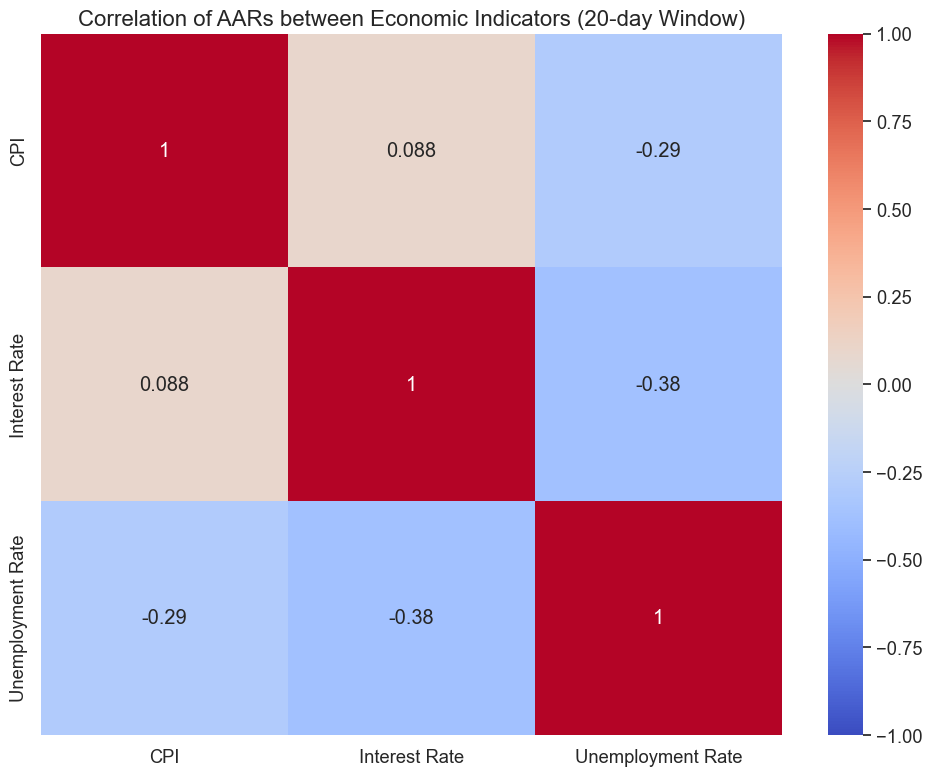

ANOVA results for 20-day window:
F-statistic: 0.6221, P-value: 0.5386

Pairwise t-test results for 20-day window:


,T-Statistic,P-Value,Significant
Comparison,,,
CPI vs Interest Rate,-0.9269,0.3570,0.0000
CPI vs Unemployment Rate,0.2498,0.8034,0.0000
Interest Rate vs Unemployment Rate,1.0674,0.2893,0.0000



Summary Comparison Across All Window Sizes:


,CPI_T-Stat,Interest Rate_T-Stat,Unemployment Rate_T-Stat,CPI_P-Value,Interest Rate_P-Value,Unemployment Rate_P-Value
5,0.1356,1.1136,-0.4313,0.8922,0.2659,0.6664
10,-0.3310,0.2329,-0.6780,0.7407,0.8159,0.4979
20,0.1849,-0.1720,-0.3908,0.8533,0.8635,0.6960


In [1]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import os
from IPython.display import display

# Set the Seaborn style for all plots
sns.set_theme(style="whitegrid")
sns.set_context("notebook", font_scale=1.2)

# Custom colour palette
indicator_colour_palette = sns.color_palette("deep", 3)

# Fetch FTSE 100 data for the last 10 years using the yfinance library
ftse100_ticker = yf.Ticker("^FTSE")
ftse100_historical_data = ftse100_ticker.history(period="10y")

# Display the first few rows of the fetched data
print(ftse100_historical_data.head())

# Ensure the directory exists before saving the data
output_directory = "data"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Save the FTSE 100 data to a CSV file
ftse100_historical_data.to_csv(os.path.join(output_directory, "ftse100_historical_data.csv"))

# Load the saved FTSE 100 data from the CSV file
ftse100_data_loaded = pd.read_csv("data/ftse100_historical_data.csv")

# Convert the 'Date' column to datetime format for further analysis
ftse100_data_loaded['Date'] = pd.to_datetime(ftse100_data_loaded['Date'], utc=True)

# Extract the 'Date' and 'Close' columns
ftse100_closing_prices = ftse100_data_loaded[['Date', 'Close']].copy()

# Format the 'Date' column to remove the timestamp
ftse100_closing_prices['Date'] = ftse100_closing_prices['Date'].dt.date

# Display the first few rows of the 'Date' and 'Close' data
print(ftse100_closing_prices.head())

# Save the Closing prices data to a CSV file
ftse100_closing_prices.to_csv('data/ftse100_closing_prices.csv', index=False)

# Load indicator release dates from a CSV file
indicator_release_dates = pd.read_csv('data/dates.csv')

indicator_release_dates['Release Date'] = pd.to_datetime(indicator_release_dates['Release Date'], utc=True)
indicator_release_dates['Release Date'] = indicator_release_dates['Release Date'].dt.date

# Split the dataset into separate DataFrames based on 'Indicator' values
interest_rate_release_dates = indicator_release_dates[indicator_release_dates['Indicator'] == 'Interest Rate']
cpi_release_dates = indicator_release_dates[indicator_release_dates['Indicator'] == 'CPI']
unemployment_rate_release_dates = indicator_release_dates[indicator_release_dates['Indicator'] == 'Unemployment Rate']

# Save each indicator's release indicator_release_dates to separate CSV files
interest_rate_release_dates.to_csv('data/interest_rate_release_dates.csv', index=False)
cpi_release_dates.to_csv('data/cpi_release_dates.csv', index=False)
unemployment_rate_release_dates.to_csv('data/ unemployment_rate_release_dates.csv', index=False)

# Load datasets
ftse100_data = pd.read_csv('data/ftse100_closing_prices.csv')
cpi_release_dates = pd.read_csv('data/cpi_release_dates.csv')
interest_rate_release_dates = pd.read_csv('data/interest_rate_release_dates.csv')
unemployment_rate_release_dates = pd.read_csv('data/ unemployment_rate_release_dates.csv')

# Sort the FTSE 100 data by date
ftse100_data_sorted = ftse100_data.sort_values(by='Date')

# Calculate daily returns as percentage change in 'Close' prices
ftse100_data_sorted['Return'] = ftse100_data_sorted['Close'].pct_change()

# Remove the first NaN value in 'Return' column
ftse100_data_cleaned = ftse100_data_sorted.dropna(subset=['Return'])

# Function to get event windows
def get_event_windows(market_data, event_dates, window_days):

    """
    Get the event windows around specified event dates.

    Parameters:
    market_data (pd.DataFrame): DataFrame containing the market data with a 'Date' column.
    event_dates (pd.DataFrame): DataFrame containing the event dates with a 'Release Date' column.
    window_days (int): Number of days before and after the event date to include in the window.

    Returns:
    pd.DataFrame: A DataFrame containing the market data for the specified event windows,
                  with an additional column 'Days_From_Event' indicating the number of days
                  from the event date.
    """

    # Make a copy of the market data to avoid modifying the original DataFrame
    market_data = market_data.copy()

    # Convert 'Date' columns to datetime format
    market_data['Date'] = pd.to_datetime(market_data['Date'])
    event_dates['Release Date'] = pd.to_datetime(event_dates['Release Date'])

    # Create event windows for each event date
    event_windows = pd.concat([
        market_data[(market_data['Date'] >= (event_date - pd.Timedelta(days=window_days))) & 
                    (market_data['Date'] <= (event_date + pd.Timedelta(days=window_days)))]
                   .assign(Days_From_Event=(market_data['Date'] - event_date).dt.days)
        for event_date in event_dates['Release Date']
    ], ignore_index=True)

    # The 'Days_From_Event' column represents the number of days relative to the event date
    # Negative values are days before the event, 0 is the event day, and positive values are days after the event

    return event_windows

# Function to plot returns
def plot_returns(data_frame, x_column, y_column, plot_title, x_label, y_label, marker='o', linestyle='-', line_colour='blue'):

    """
    Plot returns using Seaborn lineplot.

    Parameters:
    data_frame (pd.DataFrame): DataFrame containing the data to plot.
    x_column (str): Column name for the x-axis data.
    y_column (str): Column name for the y-axis data.
    plot_title (str): Title of the plot.
    x_label (str): Label for the x-axis.
    y_label (str): Label for the y-axis.
    marker (str): Marker style for the plot. Default is 'o'.
    linestyle (str): Line style for the plot. Default is '-'.
    line_colour (str): Colour of the line. Default is 'blue'.

    Returns:
    None: The function directly displays the plot.
    """

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=data_frame, x=x_column, y=y_column, marker=marker, linestyle=linestyle, color=line_colour)
    plt.axhline(0, color='gray', linestyle='--')
    plt.title(plot_title, fontsize=16)
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.tight_layout()
    plt.show()

# Function to plot average abnormal returns
def plot_average_abnormal_returns(event_windows, event_name, marker='o', line_style='-', line_colour='blue'):

    """
    Plot average abnormal returns around specified event dates.

    Parameters:
    event_windows (pd.DataFrame): DataFrame containing event window data with 'Days_From_Event' and 'Abnormal Return' columns.
    event_name (str): Name of the event to be used in the plot title.
    marker (str): Marker style for the plot. Default is 'o'.
    line_style (str): Line style for the plot. Default is '-'.
    line_colour (str): Colour of the line. Default is 'blue'.

    Returns:
    None: The function directly displays the plot.
    """

    avg_abnormal_returns = event_windows.groupby('Days_From_Event')['Abnormal Return'].mean().reset_index()
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=avg_abnormal_returns, x='Days_From_Event', y='Abnormal Return', 
                 marker=marker, linestyle=line_style, color=line_colour)
    plt.axhline(0, color='gray', linestyle='--')
    plt.title(f'Mean Abnormal Returns Around {event_name} Release Dates', fontsize=16)
    plt.xlabel('Days From Event', fontsize=14)
    plt.ylabel('Abnormal Return', fontsize=14)
    plt.tight_layout()
    plt.show()

# Function to conduct event study
def event_study(ftse_data, event_dates, event_name, window_days):

    """
    Conduct an event study by analysing abnormal returns around specified event dates.

    Parameters:
    ftse_data (pd.DataFrame): DataFrame containing the FTSE data with 'Date' and 'Return' columns.
    event_dates (pd.DataFrame): DataFrame containing the event dates with a 'Release Date' column.
    event_name (str): Name of the event to be used in analysis and plotting.
    window_days (int): Number of days before and after the event date to include in the window.

    Returns:
    tuple: t-statistic, p-value, and DataFrame containing the event windows and abnormal returns.
    """

    event_windows = get_event_windows(ftse_data, event_dates, window_days)

    # Replace infinite values with NaN to prevent issues in statistical calculations
    event_windows.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Calculate the baseline mean return from non-event days
    # This serves as the simple expected return model
    baseline_mean_return = ftse_data[~ftse_data['Date'].isin(event_windows['Date'])]['Return'].mean()

    # Calculate abnormal returns by subtracting the baseline mean return from actual returns
    event_windows['Abnormal Return'] = event_windows['Return'] - baseline_mean_return

    # Perform a t-test to determine if the abnormal returns are significantly different from zero
    # The null hypothesis is that the mean abnormal return is zero
    t_statistic, p_value = stats.ttest_1samp(event_windows['Abnormal Return'].dropna(), 0)

    # Plot the average abnormal returns
    plot_average_abnormal_returns(event_windows, event_name)

    return t_statistic, p_value, event_windows

# Function to calculate AAR and CAR
def calculate_aar_car(event_window_data):

    """
    Calculate Average Abnormal Return (AAR) and Cumulative Abnormal Return (CAR).

    Parameters:
    event_window_data (pd.DataFrame): DataFrame containing event window data with 'Days_From_Event' and 'Abnormal Return' columns.

    Returns:
    tuple: Two pd.Series objects - AAR and CAR.
        average_abnormal_return: Average Abnormal Return for each day relative to the event.
        cumulative_abnormal_return: Cumulative Abnormal Return, which is the cumulative sum of AARs over the event window.
    """

    # Calculate Average Abnormal Return (AAR) for each day relative to the event
    average_abnormal_return = event_window_data.groupby('Days_From_Event')['Abnormal Return'].mean()

    # Calculate Cumulative Abnormal Return (CAR) by taking the cumulative sum of AAR
    # This shows the cumulative effect of the event over time
    cumulative_abnormal_return = average_abnormal_return.cumsum()

    return average_abnormal_return, cumulative_abnormal_return

# Function to plot AAR for multiple windows
def plot_aar_multiple_windows(aar_data_dict):
    """
    Plot Average Abnormal Return (AAR) for multiple event window sizes.

    This function creates a multi-panel plot, with each panel representing
    a different event window size. Within each panel, the AAR for different
    economic indicators is plotted against the days from the event.

    Parameters:
    aar_data_dict (dict): A nested dictionary structure where the outer key is the
                          window size, and the inner key is the indicator name.
                          The values are DataFrames containing 'Days_From_Event' and 'AAR'.

    Returns:
    None: The function displays the plot directly.
    """
    plt.figure(figsize=(15, 10))
    
    # Iterate over each window size
    for window_size, indicators in aar_data_dict.items():
        # Create a subplot for each window size
        plt.subplot(len(event_window_sizes), 1, event_window_sizes.index(window_size) + 1)
        
        # Plot each indicator's AAR
        for i, (event_name, df) in enumerate(indicators.items()):
            sns.lineplot(data=df, x='Days_From_Event', y='AAR',
                         marker='o', label=event_name, color=indicator_colour_palette[i])
        
        # Set title and labels for the subplot
        plt.title(f'Average Abnormal Return (AAR) - Window Size: {window_size} days')
        plt.xlabel('Days From Event')
        plt.ylabel('AAR')
        
        # Add a horizontal line at y=0 for reference
        plt.axhline(0, color='gray', linestyle='--')
        
        # Add a legend
        plt.legend(title='Indicator', title_fontsize='10', fontsize='8')
    
    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()

# Function to plot CAR
def plot_car(car_data_dict, window_size):
    """
    Plot Cumulative Abnormal Return (CAR) for a specific event window size.

    This function creates a single plot showing the CAR for different economic
    indicators over the event window period.

    Parameters:
    car_data_dict (dict): A dictionary where keys are indicator names and values
                          are DataFrames containing 'Days_From_Event' and 'CAR'.
    window_size (int): The size of the event window in days.

    Returns:
    None: The function displays the plot directly.
    """
    plt.figure(figsize=(12, 6))
    
    # Plot CAR for each economic indicator
    for i, (event_name, df) in enumerate(car_data_dict.items()):
        sns.lineplot(data=df, x='Days_From_Event', y='CAR',
                     marker='o', label=event_name, color=indicator_colour_palette[i])
    
    # Set title and labels
    plt.title(f'Cumulative Abnormal Return (CAR) by Economic Indicator ({window_size}-day Window)', fontsize=16)
    plt.xlabel('Days From Event', fontsize=14)
    plt.ylabel('Cumulative Abnormal Return (CAR)', fontsize=14)
    
    # Add a horizontal line at y=0 for reference
    plt.axhline(0, color='gray', linestyle='--')
    
    # Add a legend
    plt.legend(title='Indicator', title_fontsize='13', fontsize='11')
    
    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()

# Function to create a heatmap of correlations
def plot_correlation_heatmap(aar_data, window_size):
    
    """
    Plot a correlation heatmap of Average Abnormal Returns (AARs) between different economic indicators.

    This function creates a heatmap visualization of the correlation matrix
    computed from the AARs of different economic indicators. It helps in 
    understanding the relationships between the impacts of various economic
    indicators on the market.

    Parameters:
    aar_data (pandas.DataFrame): A DataFrame containing the AAR data for different
                                 economic indicators. Each column should represent
                                 an indicator, and each row should represent a time point.
    window_size (int): The size of the event window in days, used for the plot title.

    Returns:
    None: The function displays the plot directly.

    Note:
    - The heatmap uses a 'coolwarm' color palette, with red indicating positive
      correlations and blue indicating negative correlations.
    - The correlation values are annotated on each cell of the heatmap.
    """

    # Create a new figure with specified size
    plt.figure(figsize=(10, 8))

    # Generate and plot the correlation heatmap
    sns.heatmap(
        aar_data.corr(),  # Compute the correlation matrix
        annot=True,       # Annotate each cell with the numeric value
        cmap='coolwarm',  # Use a diverging color palette
        vmin=-1, vmax=1,  # Set the range of values to [-1, 1] for correlation
        center=0          # Center the colormap at 0
    )

    # Set the title of the plot
    plt.title(f'Correlation of AARs between Economic Indicators ({window_size}-day Window)', fontsize=16)

    # Adjust the layout to prevent clipping of labels
    plt.tight_layout()

    # Display the plot
    plt.show()

# Function to create a summary table for all window sizes
def create_summary_table(results):
    
    """
    Create a summary table of event study results.

    Parameters:
    results (dict): A dictionary containing event study results.

    Returns:
    pd.DataFrame: A summary table of results.
    """

    summary = []
    for window_size, indicators in results.items():
        for indicator, data in indicators.items():
            summary.append({
                'Window Size': window_size,
                'Indicator': indicator,
                'T-Statistic': data['t_statistic'],
                'P-Value': data['p_value']
            })
    return pd.DataFrame(summary)

# Function to style a DataFrame
def style_dataframe(df):

    """
    Apply styling to a DataFrame for better visualisation.

    Parameters:
    df (pd.DataFrame): DataFrame to be styled.

    Returns:
    pd.io.formats.style.Styler: A Styler object with the applied styles.
    """

    return df.style.background_gradient(cmap='coolwarm', axis=1)\
                   .highlight_max(color='lightgreen', axis=1)\
                   .highlight_min(color='lightcoral', axis=1)\
                   .format('{:.4f}')

# Define multiple event window sizes (days before and after the event)
event_window_sizes = [5, 10, 20]

# Dictionary to store results for each indicator and window size
event_study_results = {}

# Perform event study for each window size and indicator
for window_size in event_window_sizes:
    event_study_results[window_size] = {}
    
    # Iterate over each indicator and its corresponding event dates
    for indicator_name, indicator_dates in zip(['CPI', 'Interest Rate', 'Unemployment Rate'], 
                                       [cpi_release_dates, interest_rate_release_dates, unemployment_rate_release_dates]):
        # Perform event study for each economic indicator and window size
        t_statistic, p_value, event_windows = event_study(ftse100_data_cleaned, indicator_dates, indicator_name, window_size)
        event_study_results[window_size][indicator_name] = {'t_statistic': t_statistic, 'p_value': p_value, 'event_windows': event_windows}
        print(f"Window Size: {window_size}, {indicator_name} Releases: T-Statistic = {t_statistic:.4f}, P-Value = {p_value:.4f}")

# Create and display the summary table
summary_table = create_summary_table(event_study_results)
styled_summary = style_dataframe(summary_table.set_index(['Window Size', 'Indicator']))
display(styled_summary)

# Calculate AAR and CAR for each indicator and window size
aar_car_results = {
        window_size: {
            event_name: calculate_aar_car(data['event_windows']) 
            for event_name, data in indicators.items()
        } for window_size, indicators in event_study_results.items()
    }

aar_dataframes = {
    window_size: {
        event_name: aar.reset_index(name='AAR') 
        for event_name, (aar, car) in indicators.items()
    } for window_size, indicators in aar_car_results.items()
}

 # Plot AAR for different window sizes
plot_aar_multiple_windows(aar_dataframes)

# Perform detailed analysis for all window sizes
for window_size in event_window_sizes:
    print(f"\nAnalysis for {window_size}-day event window:")
        
    aar_car_results_window = aar_car_results[window_size]
    aar_dataframes_window = aar_dataframes[window_size]
    car_dataframes_window = {event_name: car.reset_index(name='CAR') 
                              for event_name, (aar, car) in aar_car_results_window.items()}

    # Plot CAR for current window size
    plot_car(car_dataframes_window, window_size)

    # Combine AAR data for correlation analysis and summary statistics
    combined_aar_data_for_tables = pd.DataFrame({
        'CPI': aar_dataframes_window['CPI']['AAR'],
        'Interest Rate': aar_dataframes_window['Interest Rate']['AAR'],
        'Unemployment Rate': aar_dataframes_window['Unemployment Rate']['AAR']
        })
    
    # Display summary statistics
    summary_statistics = combined_aar_data_for_tables.describe()
    styled_summary = style_dataframe(summary_statistics)
    display(styled_summary)

    # Plot correlation heatmap
    plot_correlation_heatmap(combined_aar_data_for_tables, window_size)

  # The summary table provides a concise overview of the event study results for different economic indicators and window sizes
  # The 'T-Statistic' column shows the t-statistic value for the null hypothesis that the mean abnormal return is zero
  # The 'P-Value' column shows the p-value associated with the t-statistic

  # Perform ANOVA test
    f_statistic, anova_p_value = stats.f_oneway(
        combined_aar_data_for_tables['CPI'].dropna(),
        combined_aar_data_for_tables['Interest Rate'].dropna(),
        combined_aar_data_for_tables['Unemployment Rate'].dropna()
    )

    print(f"ANOVA results for {window_size}-day window:")
    print(f"F-statistic: {f_statistic:.4f}, P-value: {anova_p_value:.4f}")

  # The ANOVA test is used to determine if there are statistically significant differences between the average abnormal returns of different economic indicators
  # The null hypothesis is that the means of the abnormal returns are equal across all indicators
  # The p-value indicates the probability of observing the data if the null hypothesis is true

  # Perform pairwise t-tests with Bonferroni correction
    num_comparisons = 3
    significance_level = 0.05
    bonferroni_corrected_alpha = significance_level / num_comparisons

    pairwise_t_test_results = [
        ('CPI vs Interest Rate', stats.ttest_ind(combined_aar_data_for_tables['CPI'].dropna(), combined_aar_data_for_tables['Interest Rate'].dropna())),
        ('CPI vs Unemployment Rate', stats.ttest_ind(combined_aar_data_for_tables['CPI'].dropna(), combined_aar_data_for_tables['Unemployment Rate'].dropna())),
        ('Interest Rate vs Unemployment Rate', stats.ttest_ind(combined_aar_data_for_tables['Interest Rate'].dropna(), combined_aar_data_for_tables['Unemployment Rate'].dropna()))
    ]

  # Display t-test results
    t_test_results_df = pd.DataFrame({
        'Comparison': [res[0] for res in pairwise_t_test_results],
        'T-Statistic': [res[1].statistic for res in pairwise_t_test_results],
        'P-Value': [res[1].pvalue for res in pairwise_t_test_results],
        'Significant': [res[1].pvalue < bonferroni_corrected_alpha for res in pairwise_t_test_results]
    })
    print(f"\nPairwise t-test results for {window_size}-day window:")
    display(style_dataframe(t_test_results_df.set_index('Comparison')))

  # The pairwise t-tests with Bonferroni correction are used to compare the average abnormal returns between different economic indicators

  # Summary comparison across all window sizes
    print("\nSummary Comparison Across All Window Sizes:")
    summary_comparison = pd.DataFrame({
        window_size: {
            f"{indicator}_T-Stat": results[indicator]['t_statistic']
            for indicator in results
        } | {
            f"{indicator}_P-Value": results[indicator]['p_value']
            for indicator in results
        }
        for window_size, results in event_study_results.items()
    })
    display(style_dataframe(summary_comparison.T))

# The 'Significant' column indicates whether the difference between indicators is statistically significant
# after applying the Bonferroni correction to control for multiple comparisons